#Proyecto de Detección de Cascos en Motociclistas

#Definición del Problema
Área: Seguridad vial

Problema: Detección de motociclistas que no usan casco

Relevancia: El casco reduce significativamente el riesgo de lesiones graves en accidentes de moto. Un sistema automático de detección podría ayudar en controles de tránsito o sistemas de vigilancia.

Objetivos: Desarrollar un sistema que clasifique imágenes de motociclistas en "con casco" y "sin casco" usando técnicas de PDI.

#Diseño de la Solución

Preprocesamiento de imágenes (redimensionamiento, conversión a escala de grises)

Extracción de características (usando Histogramas de Gradientes Orientados - HOG) Consiste en descomponer imágenes en una matriz densa de celdas y calcular un histograma de gradientes para cada celda, que posteriormente se normaliza mediante la superposición del contraste celular local.

Entrenamiento de un clasificador SVM (Máquinas de Vectores de Soporte)

Evaluación del modelo

Herramientas:

Python

OpenCV (para procesamiento de imágenes)

Scikit-learn (para el modelo SVM)

Matplotlib (para visualización)

# Paso 1: preparar las imágenes y etiquetas

Leer las imágenes

Asignarles la etiqueta correcta

Guardarlas listas para procesar

In [12]:
import cv2
import os
import numpy as np
import glob

# Nuevas rutas
ruta_casco = '/content/drive/MyDrive/TPI_Proyecto_Final/con_casco/*.jpg'
ruta_sin_casco = '/content/drive/MyDrive/TPI_Proyecto_Final/sin_casco/*.jpg'

imagenes = []
etiquetas = []

# Cargar imágenes CON casco
for ruta in glob.glob(ruta_casco):
    imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    if imagen is not None:
        imagen = cv2.resize(imagen, (128, 128))
        imagenes.append(imagen)
        etiquetas.append(1)  # etiqueta para "con casco"

# Cargar imágenes SIN casco
for ruta in glob.glob(ruta_sin_casco):
    imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    if imagen is not None:
        imagen = cv2.resize(imagen, (128, 128))
        imagenes.append(imagen)
        etiquetas.append(0)  # etiqueta para "sin casco"

print(f'✅ Se cargaron {len(imagenes)} imágenes.')



✅ Se cargaron 27 imágenes.


##Parte 2: extracción de características con HOG
¿Qué es HOG?
HOG (Histogram of Oriented Gradients) es una técnica para describir la forma de los objetos en una imagen:

Divide la imagen en pequeñas celdas.

Calcula la dirección (orientación) de los bordes en cada celda.

Usa eso como "firma" del objeto.

In [13]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Paso 1: convertimos cada imagen a su descriptor HOG
hog_features = []

for imagen in imagenes:
    # Extraemos las características HOG de la imagen
    features = hog(imagen, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys')

    hog_features.append(features)

# Convertimos a array para poder usarlo en sklearn
X = np.array(hog_features)
y = np.array(etiquetas)

# Paso 2: dividimos en entrenamiento y prueba (80% entrenamiento, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 3: entrenamos el clasificador SVM
modelo = LinearSVC()
modelo.fit(X_train, y_train)

# Paso 4: probamos con el conjunto de prueba
y_pred = modelo.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Precisión del modelo: {accuracy * 100:.2f}%")


✅ Precisión del modelo: 83.33%


#Paso 3: Probar con una imagen nueva
Vamos a cargar una imagen, procesarla, extraer sus características HOG, y hacer que el modelo prediga si la persona tiene casco o no.

In [33]:
# Elegí la imagen que querés probar
nombre_imagen_prueba = "moto17.jpg"  # cambiá esto si querés otra

# Ruta a la imagen
carpeta_imagenes = "/content/drive/MyDrive/TPI_Proyecto_Final/sin_casco"
nombre_imagen_prueba = "moto17.jpg"
ruta_prueba = os.path.join(carpeta_imagenes, nombre_imagen_prueba)

# Cargamos y procesamos
imagen_prueba = cv2.imread(ruta_prueba, cv2.IMREAD_GRAYSCALE)

if imagen_prueba is None:
    print("❌ No se pudo cargar la imagen.")
else:
    # Redimensionamos igual que antes
    imagen_prueba = cv2.resize(imagen_prueba, (128, 128))

    # Extraemos HOG
    features_prueba = hog(imagen_prueba, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys')

    # Predecimos
    prediccion = modelo.predict([features_prueba])[0]

    # Mostramos resultado
    texto_resultado = "✅ CON casco" if prediccion == 1 else "❌ SIN casco"
    print(f"La imagen {nombre_imagen_prueba} fue clasificada como: {texto_resultado}")


La imagen moto17.jpg fue clasificada como: ❌ SIN casco


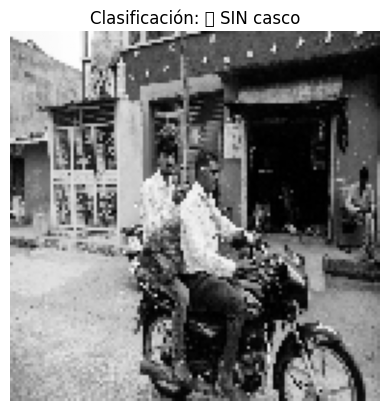

In [34]:
import matplotlib.pyplot as plt

# Mostrar la imagen con el resultado
plt.imshow(imagen_prueba, cmap='gray')
plt.title(f"Clasificación: {texto_resultado}")
plt.axis('off')
plt.show()


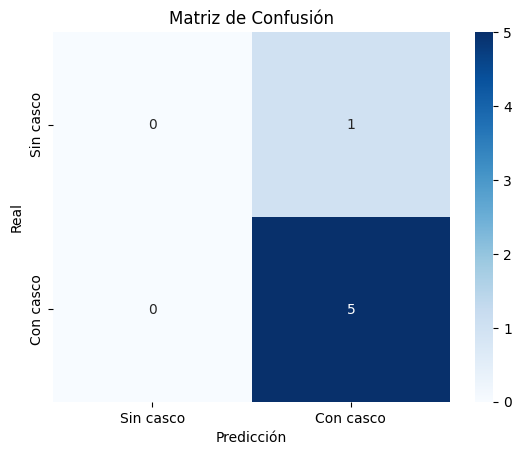

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

   Sin casco       0.00      0.00      0.00         1
   Con casco       0.83      1.00      0.91         5

    accuracy                           0.83         6
   macro avg       0.42      0.50      0.45         6
weighted avg       0.69      0.83      0.76         6



In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sin casco", "Con casco"], yticklabels=["Sin casco", "Con casco"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Reporte de clasificación
print("📋 Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["Sin casco", "Con casco"]))


In [18]:
import joblib

# Guardar modelo
joblib.dump(modelo, "modelo_svm_cascos.pkl")
print("💾 Modelo guardado como modelo_svm_cascos.pkl")


💾 Modelo guardado como modelo_svm_cascos.pkl


In [ ]:
"""modelo_cargado = joblib.load("modelo_svm_cascos.pkl")"""


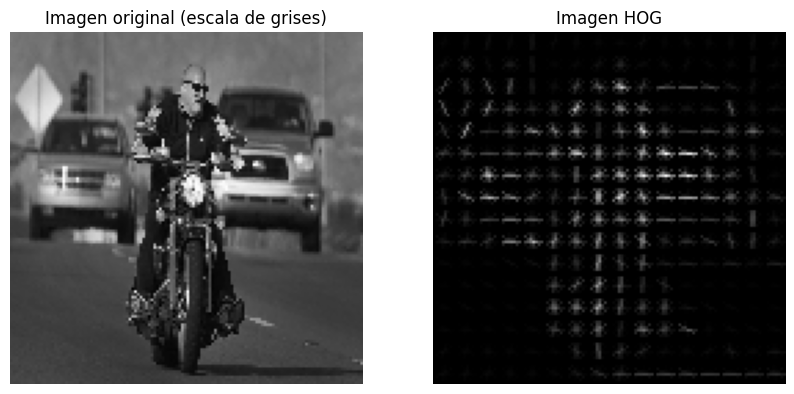

In [28]:
from skimage import color, exposure
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog

# Load the image directly as grayscale
imagen_ejemplo_path = "/content/drive/MyDrive/TPI_Proyecto_Final/test_nuevas/moto28.jpg"
imagen_gris = cv2.imread(imagen_ejemplo_path, cv2.IMREAD_GRAYSCALE)

if imagen_gris is not None:
    # Resize the image to match the training data size
    imagen_gris_resized = cv2.resize(imagen_gris, (128, 128))

    # Extract HOG features and the HOG image
    hog_features, hog_image = hog(imagen_gris_resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    # Display the original grayscale image
    plt.imshow(imagen_gris_resized, cmap='gray')
    plt.title("Imagen original (escala de grises)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap="gray")
    plt.title("Imagen HOG")
    plt.axis('off')
    plt.show()
else:
    print("Error: No se pudo cargar la imagen de ejemplo.")

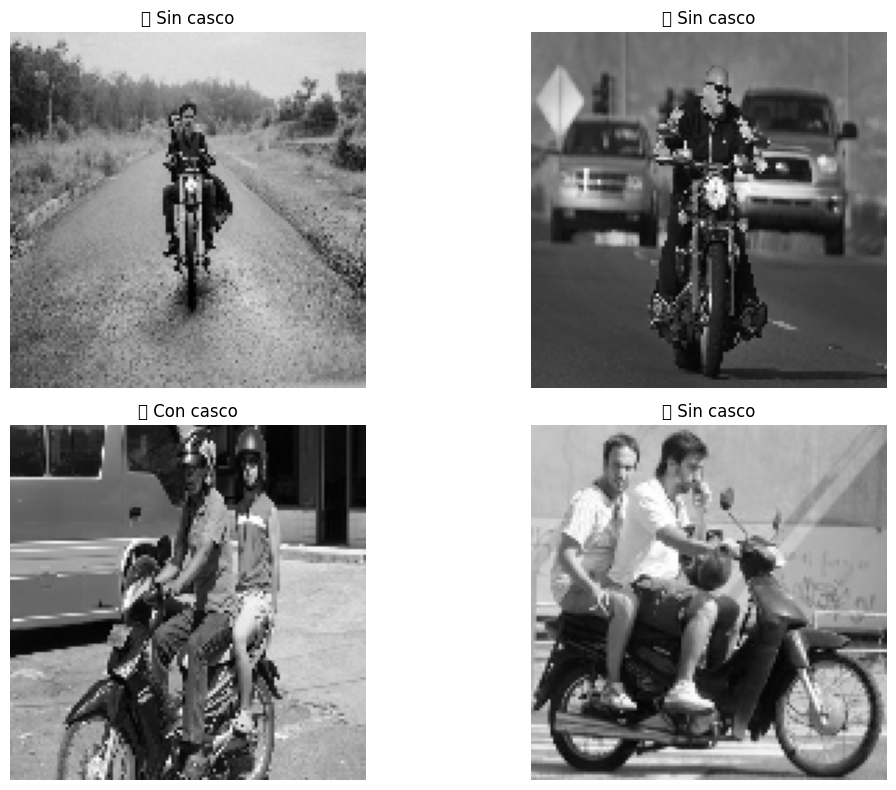

In [31]:
from glob import glob

# Buscar todas las imágenes en carpeta test_nuevas
carpeta_test = "/content/drive/MyDrive/TPI_Proyecto_Final/test_nuevas/"
imagenes_test = glob(os.path.join(carpeta_test, "*.jpg"))

# Mostrar hasta 4 predicciones
plt.figure(figsize=(12, 8))
for i, ruta in enumerate(imagenes_test[:4]):
    imagen = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
    imagen = cv2.resize(imagen, (128, 128))
    features = hog(imagen, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys')

    pred = modelo.predict([features])[0]
    etiqueta = "✅ Con casco" if pred == 1 else "❌ Sin casco"

    plt.subplot(2, 2, i+1)
    plt.imshow(imagen, cmap='gray')
    plt.title(etiqueta)
    plt.axis('off')

plt.tight_layout()
plt.show()
